# Statistical analysis of speech sound chirpiness

In this notebook we analyse the speech sound chirpiness.
We postulate that the chirpiness is distributed following the Cauchy distribution $\mathcal{C}(x_0,\gamma)$.

In [1]:
import Pkg
Pkg.activate("..")
import WCA1

 Activating environment at `/mnt/data/L2S/myWCA1/Project.toml`


In [2]:
import WAV
x, fs = WAV.wavread("../samples/speech_signal_example.wav")
x = reshape(x, length(x))
X = WCA1.stft(x, 1000, 900; fs=fs, window=WCA1.hanning)
V = vec(WCA1.compute_slopes(X));

$$
\def\R{\mathbb{R}}
\def\FT{\mathcal{F}}
\def\STFT{\mathrm{STFT}}
\def\dt{\mathrm{d}t}
\def\dw{\mathrm{d}\omega}
\def\med{\mathrm{median}}
\newcommand\abs[1]{\left\lvert#1\right\rvert}
$$

## Cauchy estimation

In this part we attempt to estimate the parameters of the Cauchy distribution that best describes the chirpiness.

In the litterature, the parameters of the Cauchy distribution can be estimated with different methods:

- Estimating $x_0$:
  - The sample median $\med(X)$
  - Maximum Likelihood Estimator (MLE)
- Estimating $\gamma$:
  - The median of the absolute values of the data $\med(\abs{X})$
  - Half of the interquartile range (the difference between the 75th and the 25th percentile).

In the following code we implement 4 estimators of the parameters $(x_0,\gamma)$.
- `cauchy_median`: $\mathcal{C}(\med(X), \med(\abs{X})$.
- `cauchy_interquartile`: $\mathcal{C}(\med(X), (Q(75\%) - Q(50\%))/2)$.
- `cauchy_mle`: $\mathcal{C}(\mathrm{MLE}(X), \med(\abs{X})$.
- `cauchy_mixed`: $\mathcal{C}(\mathrm{MLE}(X), (\med(\abs{X}) + (Q(75\%) - Q(50\%))/2))$.

In [8]:
using Distributions, StatsBase, HypothesisTests, LinearAlgebra
using Plots, Glob

# Cauchy estimators
cauchy_median(data) = Cauchy(median(data), median(abs.(data)))
cauchy_interquartile(data) = Cauchy(median(data), percentile(data, 75) - percentile(data, 25)/2)
cauchy_mle(data) = fit(Cauchy, data)
function cauchy_mixed(data)
    mle = cauchy_mle(data)
    percent = cauchy_interquartile(data)
    Cauchy(mle.μ, (percent.σ + mle.σ)/2)
end

# Calculates L∞ distance between two vectors
max_dist(x, y) = maximum(abs.(x - y))

# Calculates point estimate of data with respect to a given distribution
function point_estimate(data::Vector{T}, d::D) where {T<:Real, D<:UnivariateDistribution}
    sorted = ecdf(data).sorted_values
    edf = collect(range(0, stop=1, length=length(sorted)))
    max_dist(edf, cdf.(d, sorted))
end

# Finds interval limits containing a percentage of the values centered around the median (of a symetrical distribution)
get_interval(d::UnivariateDistribution, p::Float64=0.95) = quantile(d, 0.5-p/2), quantile(d, 0.5+p/2)

# Calculate P[a <= X <= b]
proba(distribution, a, b) = cdf(distribution, b) - cdf(distribution, a)
proba_effective(data, a, b) = sum(a .<= data .<= b) / length(data)

proba_effective (generic function with 1 method)

Having defined these auxiliary functions, we can define a function that determines the cauchy distribution with different estimated parameters for all WAV files in a given directory and determines the interval that contains 95% of the chirpiness values centered around $x_0$.

In [9]:
# Return point estimate and effective probability for chirpiness of audio files in a given directory
function compare_slope_cauchy(samples_dir::String="./", tolerance::Real=0.95)
    lib = glob("*.wav", samples_dir)
    cauchy_dist = Dict(
        :median => cauchy_median,
        :interquartile => cauchy_interquartile,
        :mle => cauchy_mle,
        :mixed => cauchy_mixed,
    )
    pt_estimate = Dict{Symbol, Array{Float64,1}}()
    count_vals = Dict{Symbol, Array{Float64,1}}()
    interval_size = Dict{Symbol, Array{Float64,1}}()
    for mode in keys(cauchy_dist)
        pt_estimate[mode] = []
        count_vals[mode] = []
        interval_size[mode] = []
    end
    for file in lib
        data, fs = WAV.wavread(file)
        if ndims(data) > 1; data = size(data, 2) == 1 ? reshape(data, length(data)) : data[:, 1] end
        S = WCA1.stft(data, 1000, 900; fs=fs, window=WCA1.hanning)
        ν = vec(WCA1.compute_slopes(S))
        for mode in keys(cauchy_dist)
            dist = cauchy_dist[mode](ν)
            push!(pt_estimate[mode], point_estimate(ν, dist))
            a, b = get_interval(dist, tolerance)
            push!(count_vals[mode], proba_effective(ν, a, b))
            push!(interval_size[mode], b - a)
        end
    end
    return pt_estimate, count_vals, interval_size
end

compare_slope_cauchy (generic function with 3 methods)

In [10]:
pt_estimate, proba_eff, interval_size = compare_slope_cauchy("../samples/speech_lib", 0.95);

Let's plot the point estimates for all the audio files.

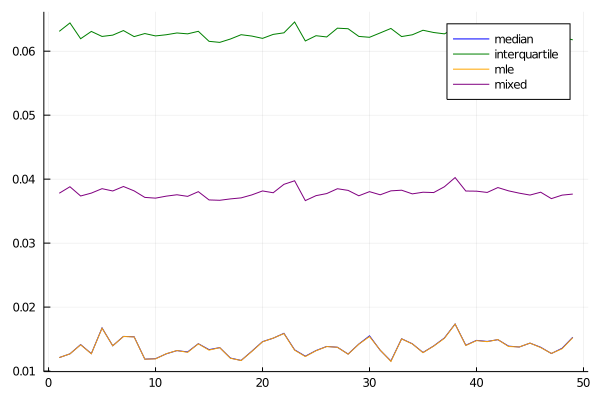

In [11]:
plot(pt_estimate[:median], color="blue", label="median")
plot!(pt_estimate[:interquartile], color="green", label="interquartile")
plot!(pt_estimate[:mle], color="orange", label="mle")
plot!(pt_estimate[:mixed], color="purple", label="mixed")

Let's plot the ratio of values falling in the interval (that contains 95% of the Cauchy samples).

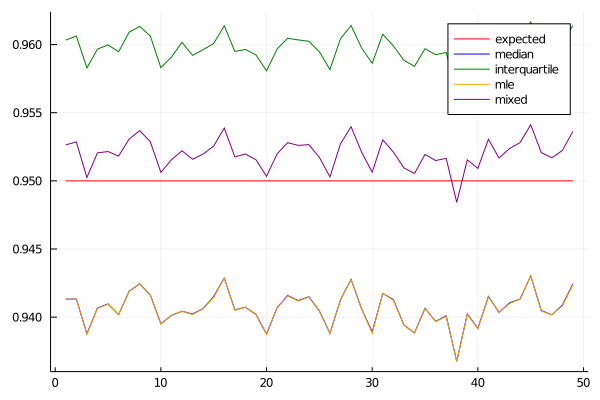

In [12]:
plot([0.95 for i in 0:length(proba_eff[:mle])-1], color="red", label="expected")
plot!(proba_eff[:median], color="blue", label="median")
plot!(proba_eff[:interquartile], color="green", label="interquartile")
plot!(proba_eff[:mle], color="orange", label="mle")
plot!(proba_eff[:mixed], color="purple", label="mixed")

Let's plot the lengths of the determined intervals.

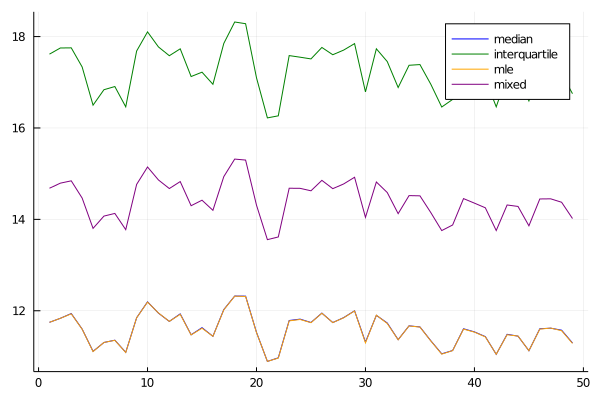

In [13]:
plot(interval_size[:median], color="blue", label="median")
plot!(interval_size[:interquartile], color="green", label="interquartile")
plot!(interval_size[:mle], color="orange", label="mle")
plot!(interval_size[:mixed], color="purple", label="mixed")

In [15]:
println("cauchy_median average interval ratio:\t", mean(proba_eff[:median]))
println("cauchy_interquartile average interval ratio:\t", mean(proba_eff[:interquartile]))
println("cauchy_mixed average interval ratio:\t", mean(proba_eff[:mixed]))

cauchy_median average interval ratio:	0.9406471962333853
cauchy_interquartile average interval ratio:	0.9597636552163878
cauchy_mixed average interval ratio:	0.9520219164664234


## Results

We can safely deduce that the MLE method returns the same results as the median estimator for $(x_0,\gamma)$.

The MLE/median estimator gives a lower point estimate than the interquartile estimation of $\gamma$.
Nevertheless, when it comes to the interval of values, the median estimator generates an interval that contains on average 94% (which is less than the espected 95%). Unlike the interquartile interval that gives on average 96%.

The mixed estimator goes to show that a simple average of the $\gamma$ values gives a ratio closer to 95%.

## `WCA1.auto_cut` implementation

Having a reasonable cutting method, we can effectively reimplement the `auto_cut` function in the `WCA1.lift` module.

In [29]:
function auto_cut(data; p = 0.95, mode=:median)
    if mode == :median
        dist = Cauchy(median(data), median(abs.(data)))
    elseif mode == :interquartile
        dist = Cauchy(median(data), percentile(data, 75) - percentile(data, 50)/2)
    elseif mode == :mle
        dist = fit_mle(Cauchy, data)
    else
        @error("Unknown mode '$(mode)'")
        return minimum(data), maximum(data)
    end
    return quantile(dist, 0.5 - p/2), quantile(dist, 0.5 + p/2)
end

function slopes(S::WCA1.STFT, N = 100; p=0.95, mode=:median, args...)
    G = WCA1.compute_slopes(S; args...)
    a, b = auto_cut(vec(G); p=p, mode=mode)
    WCA1.compute_slope_matrix(G, a, b, N)
end

function lift(m::WCA1.STFT; N::Int = 100, args...)
    slopeMatrix, Z = slopes(m, N; args...)

    imgLift = zeros(eltype(m),(size(m,1),size(m,2),N))
    for i=1:size(m,1), j=1:size(m,2)
        if slopeMatrix[i,j] != nothing
            imgLift[i,j,slopeMatrix[i,j]] = m[i,j]
        else
            imgLift[i,j,:] = ones(N)*m[i,j] / N
        end
    end

    WCA1.Lift(imgLift, WCA1.freq(m), WCA1.time(m), Z, WCA1.width(m))
end

function project(Φ::WCA1.Lift)
    f = sum(Φ[:,:,:], dims = 3) |> x->dropdims(x, dims = 3)
    WCA1.STFT(f, WCA1.freq(Φ), WCA1.time(Φ), WCA1.width(Φ))
end

project (generic function with 1 method)

Having reimplemented the `WCA1.lift` module, we can run the entire pipeline on our data.